In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
import ast
import datetime
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb

## Dataset exploration

In [2]:
df = pd.read_csv('VinIDRecruitChallenge_MLTrack_DataSet.csv')
print('Number of samples: ', len(df))

Number of samples:  131794


In [3]:
df.head()

csn        date                                   transaction_info
0  Y2NgaWJoYw==  2018-03-02  [{'article': '10020163', 'salesquantity': 2.0,...
1  Y2NgaWJoYw==  2018-03-04  [{'article': '10026562', 'salesquantity': 3.0,...
2  Y2NgaWlpYA==  2018-02-27  [{'article': '10013531', 'salesquantity': 1.0,...
3  Y2NgaWlpYA==  2018-03-16  [{'article': '10008991', 'salesquantity': 1.0,...
4  Y2NgaWlpYA==  2018-05-24  [{'article': '10009698', 'salesquantity': 1.0,...

In [4]:
df.loc[0, 'transaction_info']

"[{'article': '10020163', 'salesquantity': 2.0, 'price': 18250.0}]"

In [5]:
# some abnormal sales quantity: it is not integer numbers
df.loc[21, 'transaction_info']

"[{'article': '10053361', 'salesquantity': 0.23199999999999998, 'price': 569900.86}]"

In [6]:
csn = []
date = []
article = []
salesquantity = []
price = []
for ind in range(len(df)):
    arr = ast.literal_eval(df.loc[ind, 'transaction_info'])
    for tr in arr:
        csn += [df.loc[ind, 'csn']]
        date += [df.loc[ind, 'date']]
        article += [tr['article']]
        salesquantity += [tr['salesquantity']]
        price += [tr['price']]


In [7]:
df = pd.DataFrame(data={'csn':csn, 'date':date, 'article':article, 'salesquantity':salesquantity, 'price':price})

In [8]:
df = df.dropna(how='all') # remove samples with all missing values
print('Number of samples: ', len(df))
df.head()

Number of samples:  993512


csn        date   article  salesquantity    price
0  Y2NgaWJoYw==  2018-03-02  10020163            2.0  18250.0
1  Y2NgaWJoYw==  2018-03-04  10026562            3.0  13000.0
2  Y2NgaWJoYw==  2018-03-04  10320883            2.0  43000.0
3  Y2NgaWlpYA==  2018-02-27  10013531            1.0  17800.0
4  Y2NgaWlpYA==  2018-02-27  10015613            1.0   5600.0

In [9]:
categorical_features = ['article']
numerical_features = ['salesquantity', 'price']

In [10]:
df[numerical_features].describe()

salesquantity         price
count  993512.000000  9.935120e+05
mean        2.453600  5.847608e+04
std       123.067588  8.675746e+04
min         0.002000  1.666700e+02
25%         0.624000  1.410000e+04
50%         1.000000  3.200000e+04
75%         1.042000  6.780000e+04
max     57000.000000  5.900000e+06

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x137e6a670>,
      dtype=object)

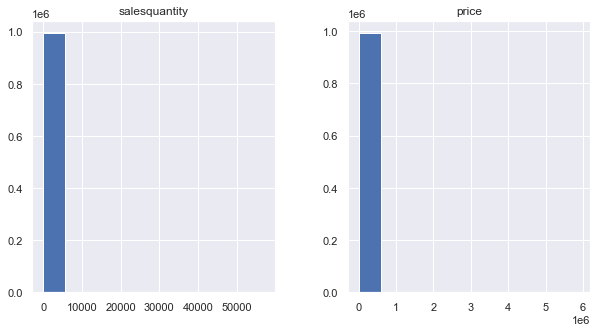

In [11]:
df[numerical_features].hist(bins=10, figsize=(10, 5))

/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


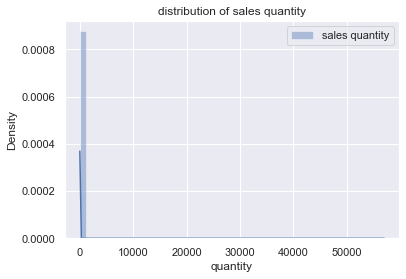

In [12]:
sns.distplot(df['salesquantity'], label='sales quantity')
plt.title('distribution of sales quantity')
plt.xlabel("quantity")
plt.legend()

/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


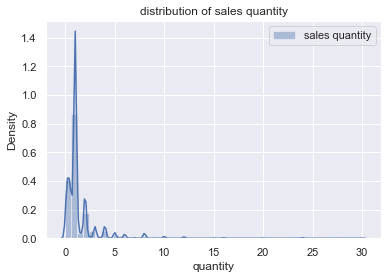

In [13]:
# distribution of sales quantity after filtering out outliers: a long-tailed distribution
selected_quantity = df.salesquantity <= 30
sns.distplot(df.loc[selected_quantity, 'salesquantity'], label='sales quantity')
plt.title('distribution of sales quantity')
plt.xlabel("quantity")
plt.legend()

/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


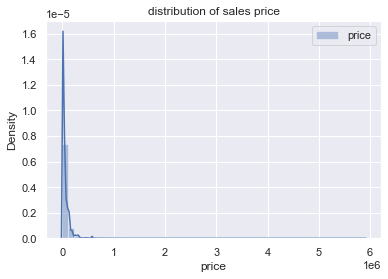

In [14]:
sns.distplot(df['price'], label='price')
plt.title('distribution of sales price')
plt.xlabel("price")
plt.legend()

## Dataset builder

In [15]:
years = []
months = []
for d in df.date:
    t = datetime.datetime.strptime(d, '%Y-%m-%d')
    years += [int(t.year)]
    months += [int(t.month)]

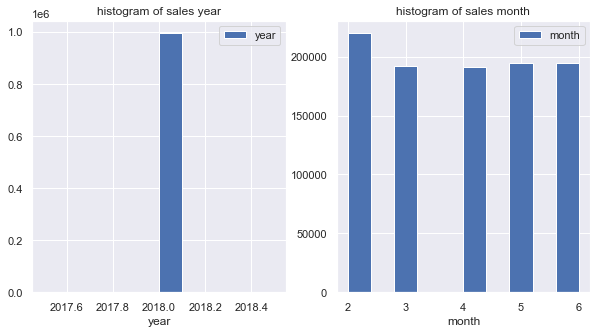

In [16]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(years, label='year')
plt.title('histogram of sales year')
plt.xlabel("year")
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(months, label='month')
plt.title('histogram of sales month')
plt.xlabel("month")
plt.legend()

In [17]:
# adding new column into dataframe
df['year'] = years
df['month'] = months
df.drop(['date'], axis=1, inplace=True)
df.head(5)

csn   article  salesquantity    price  year  month
0  Y2NgaWJoYw==  10020163            2.0  18250.0  2018      3
1  Y2NgaWJoYw==  10026562            3.0  13000.0  2018      3
2  Y2NgaWJoYw==  10320883            2.0  43000.0  2018      3
3  Y2NgaWlpYA==  10013531            1.0  17800.0  2018      2
4  Y2NgaWlpYA==  10015613            1.0   5600.0  2018      2

In [18]:
def agg_keep_first(series):
    '''Function to keep the first element in columns having same the elements.
    Parameters:
    -----------
    series: Pandas Series
        Series of road width array at each center pixels.
    Returns:
    --------
    rw: float
        Median of road width array.
    '''
    return series.values[0]

In [19]:
# processing raw data is an important task: repeated csn --> grouping them first
df = df.groupby(by=['csn', 'month']).agg({'article':agg_keep_first, 'salesquantity':sum, 'price':np.average,
                                          'year':agg_keep_first})
df = df.reset_index()
print(f'Number of remained samples: {len(df)}')
df.head()

Number of remained samples: 46312


csn  month   article  salesquantity          price  year
0  Y2NgaWJoYw==      3  10020163          7.000   24750.000000  2018
1  Y2NgaWlpYA==      2  10013531         27.000   79013.235294  2018
2  Y2NgaWlpYA==      3  10008991          6.000  115900.000000  2018
3  Y2NgaWlpYA==      5  10009698          9.000   51950.000000  2018
4  Y2NgamRpZA==      2  10010116         34.568   47494.647097  2018

In [20]:
# adding uniques integer csn_id for each csn: this is very important
u, csn_id = np.unique(df.csn.to_list(), return_inverse=True)
df.loc[:, 'csn_id'] = csn_id

In [21]:
train_df = df[np.logical_or(df.month==2, df.month==3)]
train_df = train_df.reset_index(drop=True)
thirdmonth_df = df[df.month==4]
thirdmonth_df = thirdmonth_df.reset_index(drop=True)
print(f'Number of training/third-month samples: {len(train_df)}/{len(thirdmonth_df)}')

Number of training/third-month samples: 18918/9078


In [22]:
# calculate the churn
churn = []
thirdmonth_csn = set(thirdmonth_df.csn.to_list())
for t in train_df.csn:
    if t in thirdmonth_csn:
        churn += [0]
    else:
        churn += [1]
train_df.loc[:, 'churn'] = churn
train_df.head(5)

csn  month   article  salesquantity          price  year  csn_id  \
0  Y2NgaWJoYw==      3  10020163          7.000   24750.000000  2018       0   
1  Y2NgaWlpYA==      2  10013531         27.000   79013.235294  2018       1   
2  Y2NgaWlpYA==      3  10008991          6.000  115900.000000  2018       1   
3  Y2NgamRpZA==      2  10010116         34.568   47494.647097  2018       2   
4  Y2NgamRpZA==      3  10005485         13.292   29721.925000  2018       2   

   churn  
0      1  
1      1  
2      1  
3      1  
4      1

Text(0.5, 1.0, 'churned in the training set')

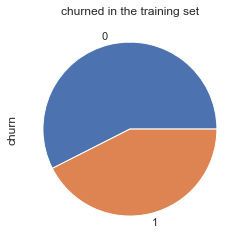

In [23]:
# around 1/4 of customers are churned out
train_df.churn.value_counts().plot(kind='pie').set_title('churned in the training set')

In [24]:
## building the testset: month 4,5,6
test_df = df[np.logical_or(df.month==4, df.month==5)]
test_df = test_df.reset_index(drop=True)
thirdmonth_df = df[df.month==6]
thirdmonth_df = thirdmonth_df.reset_index(drop=True)
print(f'Number of test/third-month samples: {len(test_df)}/{len(thirdmonth_df)}')
# calculate the churn
churn = []
thirdmonth_csn = set(thirdmonth_df.csn.to_list())
for t in test_df.csn:
    if t in thirdmonth_csn:
        churn += [0]
    else:
        churn += [1]
test_df.loc[:, 'churn'] = churn
test_df.head(5)

Number of test/third-month samples: 18184/9210


csn  month   article  salesquantity         price  year  csn_id  \
0  Y2NgaWlpYA==      5  10009698          9.000  51950.000000  2018       1   
1  Y2NgamRpZA==      5  10060637         20.782  73486.820667  2018       2   
2      Y2NgbWFn      4  10056226         23.588  49838.102857  2018       7   
3      Y2NgbWFn      5  10014961         43.378  54375.649268  2018       7   
4      Y2NgbWRn      5  10057396          6.000  36750.000000  2018       8   

   churn  
0      1  
1      0  
2      0  
3      0  
4      1

Text(0.5, 1.0, 'churned in the test set')

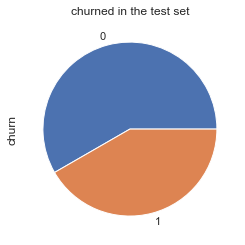

In [25]:
test_df.churn.value_counts().plot(kind='pie').set_title('churned in the test set')

## Exploring xgboost for training the model

In [26]:
# converting csn into integer numbers
print(f'Number of training samples: {len(train_df)}')
train_df.head()

Number of training samples: 18918


csn  month   article  salesquantity          price  year  csn_id  \
0  Y2NgaWJoYw==      3  10020163          7.000   24750.000000  2018       0   
1  Y2NgaWlpYA==      2  10013531         27.000   79013.235294  2018       1   
2  Y2NgaWlpYA==      3  10008991          6.000  115900.000000  2018       1   
3  Y2NgamRpZA==      2  10010116         34.568   47494.647097  2018       2   
4  Y2NgamRpZA==      3  10005485         13.292   29721.925000  2018       2   

   churn  
0      1  
1      1  
2      1  
3      1  
4      1

In [27]:
# drop `date` column in the training set because it will confuse the model as the string type
columns = ['csn_id', 'article', 'salesquantity', 'price', 'year', 'month']
label = train_df.churn
data = train_df.loc[:, columns]
# read in data
data = data.astype({'csn_id': 'int', 'article':'int'})
dtrain = xgb.DMatrix(data, label=label)

In [28]:
# specify parameters via map
param = {'max_depth':5, 'eta':1, 'objective':'binary:logistic'}
num_round = 10
bst = xgb.train(param, dtrain, num_round)

In [29]:
def test_xgb_model(bst, dtest, test_label):
    # make prediction on test data
    preds = bst.predict(dtest)
    pred_label = preds >= 0.5
    acc = sum(pred_label == test_label)/len(test_label)
    print(f'Accuracy on the test set: {acc}')
    # calculate true positive/false postive rate
    conf = confusion_matrix(y_true=test_label, y_pred=pred_label, normalize='all')
    print(f'Confusion matrix:')
    print(conf)

In [30]:
test_xgb_model(bst, dtrain, label)

Accuracy on the test set: 0.6861718997779892
Confusion matrix:
[[0.4232477  0.15139021]
 [0.16243789 0.2629242 ]]


## Make prediction on test data

In [31]:
# converting csn into integer numbers
print(f'Number of test samples: {len(test_df)}')
test_df.head()

Number of test samples: 18184


csn  month   article  salesquantity         price  year  csn_id  \
0  Y2NgaWlpYA==      5  10009698          9.000  51950.000000  2018       1   
1  Y2NgamRpZA==      5  10060637         20.782  73486.820667  2018       2   
2      Y2NgbWFn      4  10056226         23.588  49838.102857  2018       7   
3      Y2NgbWFn      5  10014961         43.378  54375.649268  2018       7   
4      Y2NgbWRn      5  10057396          6.000  36750.000000  2018       8   

   churn  
0      1  
1      0  
2      0  
3      0  
4      1

In [32]:
test_label = test_df.churn
data = test_df.loc[:, columns]
# read in data
data = data.astype({'csn_id': 'int', 'article':'int'})
dtest = xgb.DMatrix(data, label=test_label)

In [33]:
# confusion matrix: show that there is imbalanced in dataset/predictions
test_xgb_model(bst, dtest, test_label)

Accuracy on the test set: 0.6527166739991201
Confusion matrix:
[[0.44478663 0.1383634 ]
 [0.20891993 0.20793005]]


## Early stopping

In [34]:
def test_xgb_model_early_stopping(bst, dtest, test_label):
    # make prediction on test data
    preds = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
    pred_label = preds >= 0.5
    acc = sum(pred_label == test_label)/len(test_label)
    print(f'Accuracy on the test set: {acc}')
    # calculate true positive/false postive rate
    conf = confusion_matrix(y_true=test_label, y_pred=pred_label, normalize='all')
    print(f'Confusion matrix:')
    print(conf)

In [35]:
evallist = [(dtrain, 'train'), (dtest, 'eval')]
param = {'max_depth':6, 'eta':1, 'objective':'binary:logistic', 'eval_metric':'mae'}
num_round = 10

In [36]:
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10, verbose_eval=True)

[0]	train-mae:0.43239	eval-mae:0.42373
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.41694	eval-mae:0.41304
[2]	train-mae:0.40812	eval-mae:0.40891
[3]	train-mae:0.40370	eval-mae:0.40713
[4]	train-mae:0.40032	eval-mae:0.40530
[5]	train-mae:0.39726	eval-mae:0.40641
[6]	train-mae:0.39517	eval-mae:0.40639
[7]	train-mae:0.39216	eval-mae:0.40522
[8]	train-mae:0.38974	eval-mae:0.40504
[9]	train-mae:0.38932	eval-mae:0.40570


In [37]:
test_xgb_model_early_stopping(bst, dtest, test_label)

Accuracy on the test set: 0.6540365156181258
Confusion matrix:
[[0.44528157 0.13786846]
 [0.20809503 0.20875495]]


## Other loss functions: hinge-loss

In [38]:
# hinge loss is better to deal with imbalanced dataset than logistic losses
param = {'max_depth':6, 'eta':1, 'objective':'binary:hinge', 'eval_metric':'mae'}
num_round = 10

In [39]:
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10, verbose_eval=True)

[0]	train-mae:0.42711	eval-mae:0.39326
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.36859	eval-mae:0.36175
[2]	train-mae:0.34729	eval-mae:0.34404
[3]	train-mae:0.34169	eval-mae:0.34024
[4]	train-mae:0.33698	eval-mae:0.33744
[5]	train-mae:0.33508	eval-mae:0.33645
[6]	train-mae:0.33423	eval-mae:0.33738
[7]	train-mae:0.33000	eval-mae:0.33892
[8]	train-mae:0.32900	eval-mae:0.33777
[9]	train-mae:0.32588	eval-mae:0.33788


In [40]:
# testing the best model
test_xgb_model_early_stopping(bst, dtest, test_label)

Accuracy on the test set: 0.6635503739551254
Confusion matrix:
[[0.41360537 0.16954465]
 [0.16690497 0.24994501]]


## Balanced train/test set

In [41]:
# sample trainingset with balanced postive/negative samples
bal_train_df = pd.DataFrame()
num_pos = sum(train_df.churn==1)

In [42]:
bal_train_df = bal_train_df.append(train_df.loc[train_df.churn==1, :])
index = np.arange(len(train_df))
neg_index = index[train_df.churn==0]
bal_train_df = bal_train_df.append(train_df.loc[neg_index[:num_pos], :])
bal_train_df = bal_train_df.sample(frac=1)
bal_train_df = bal_train_df.sample(frac=1).reset_index(drop=True)
bal_train_df.head()

csn  month   article  salesquantity         price  year  csn_id  \
0  YmVgcGhjYw==      3  10071650         32.346  39282.754286  2018    4144   
1      ZGdgaWho      2  10053361        130.788  86989.669184  2018    9483   
2  YmlncGhoYA==      2  10058442         30.604  73385.714286  2018    6242   
3      ZGdnbWFk      3  10083185        103.264  63872.631525  2018   10147   
4  Y2RmbmFsYQ==      2  10024536         55.000  35617.592778  2018     502   

   churn  
0      0  
1      0  
2      1  
3      0  
4      1

Text(0.5, 1.0, 'balanced train set churned')

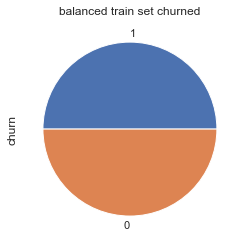

In [43]:
bal_train_df.churn.value_counts().plot(kind='pie').set_title('balanced train set churned')

In [44]:
# balanced test set
bal_test_df = pd.DataFrame()
num_pos = sum(test_df.churn==1)
bal_test_df = bal_test_df.append(test_df.loc[test_df.churn==1, :])
index = np.arange(len(test_df))
neg_index = index[test_df.churn==0]
bal_test_df = bal_test_df.append(test_df.loc[neg_index[:num_pos], :])
bal_test_df = bal_test_df.sample(frac=1)
bal_test_df = bal_test_df.sample(frac=1).reset_index(drop=True)
print(f'Number of samples in balanced train/test samples: {len(bal_train_df)}/{len(bal_test_df)}')
bal_test_df.head()

Number of samples in balanced train/test samples: 16094/15160


csn  month   article  salesquantity         price  year  csn_id  \
0  YmtobWJoZw==      5  10053671         19.470  55619.951500  2018    7057   
1      YmRibGVj      4  10054819         34.090  63168.124231  2018    3640   
2      ZGxjamps      5  10007820         28.000  21906.250000  2018   12790   
3  Y2hjbGJlZw==      4  10083091         16.118  29699.662000  2018    1373   
4  Y2hjcWNrZg==      5  10006724         10.000  26130.000000  2018    1387   

   churn  
0      1  
1      0  
2      1  
3      1  
4      1

Text(0.5, 1.0, 'balanced test set churned')

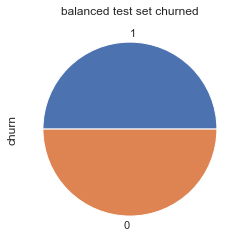

In [45]:
bal_test_df.churn.value_counts().plot(kind='pie').set_title('balanced test set churned')

In [46]:
# read in data
label = bal_train_df.churn
data = bal_train_df.loc[:, columns]
data = data.astype({'csn_id': 'int', 'article':'int'})
dtrain = xgb.DMatrix(data, label=label)
evallist = [(dtrain, 'train'), (dtest, 'eval')]
print(f'Number of training/test samples: {dtrain.num_row()}/{dtest.num_row()}')
print(dtrain.feature_names)
print(dtrain.feature_types)

Number of training/test samples: 16094/18184
['csn_id', 'article', 'salesquantity', 'price', 'year', 'month']
['int', 'int', 'float', 'float', 'int', 'int']


In [47]:
bal_test_label = bal_test_df.churn
bal_test_data = bal_test_df.loc[:, columns]
bal_test_data = bal_test_data.astype({'csn_id': 'int', 'article':'int'})
bal_dtest = xgb.DMatrix(bal_test_data, label=bal_test_label)

In [48]:
# it seems that the model has been underfit
param = {'max_depth':5, 'eta':1, 'subsample':0.5, 'lambda':2, 'objective':'binary:hinge'}
num_round = 500
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10, verbose_eval=True)
test_xgb_model_early_stopping(bst, dtest, test_label)

[0]	train-error:0.36486	eval-error:0.44253
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 10 rounds.
[1]	train-error:0.31527	eval-error:0.40558
[2]	train-error:0.30825	eval-error:0.40167
[3]	train-error:0.30042	eval-error:0.40206
[4]	train-error:0.29750	eval-error:0.39997
[5]	train-error:0.29402	eval-error:0.39958
[6]	train-error:0.29235	eval-error:0.40129
[7]	train-error:0.28824	eval-error:0.40035
[8]	train-error:0.28762	eval-error:0.39925
[9]	train-error:0.28595	eval-error:0.40228
[10]	train-error:0.28445	eval-error:0.39694
[11]	train-error:0.28433	eval-error:0.39733
[12]	train-error:0.28321	eval-error:0.39843
[13]	train-error:0.28166	eval-error:0.39914
[14]	train-error:0.27992	eval-error:0.39843
[15]	train-error:0.27768	eval-error:0.39755
[16]	train-error:0.27613	eval-error:0.39667
[17]	train-error:0.27364	eval-error:0.39942
[18]	train-error:0.27004	eval-error:0.40019
[19]	train-error:0.26929	eval

In [49]:
test_xgb_model_early_stopping(bst, bal_dtest, bal_test_label)

Accuracy on the test set: 0.720448548812665
Confusion matrix:
[[0.37559367 0.12440633]
 [0.15514512 0.34485488]]


In [50]:
# without early stopping: so hard to tune the model for xgboost
# higher number of boosted trees: 500
param = {'max_depth':5, 'eta':1, 'lambda':2, 'objective':'binary:hinge'}
bst = xgb.train(param, dtrain, num_boost_round=500, evals=evallist, verbose_eval=False)
test_xgb_model(bst, dtest, test_label)

Accuracy on the test set: 0.5957435107787066
Confusion matrix:
[[0.31863176 0.26451826]
 [0.13973823 0.27711175]]


With the balanced positive/negative samples in training set, although the accuracy of the model is low, but our xgboost model is helpful in the marketing campaining, because the model is able to pick up accurate churned customer (high recall). High-recall model is helpful in this case.

In [51]:
test_xgb_model(bst, bal_dtest, bal_test_label)

Accuracy on the test set: 0.7101583113456464
Confusion matrix:
[[0.37777045 0.12222955]
 [0.16761214 0.33238786]]


## Feature importance

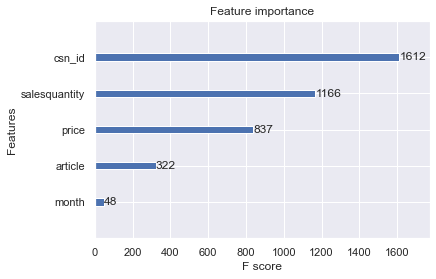

In [52]:
xgb.plot_importance(bst)

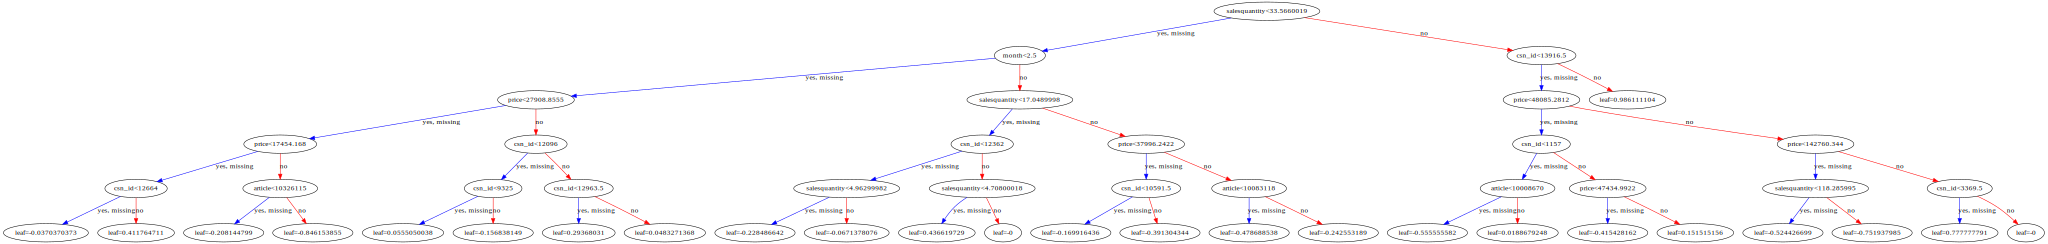

In [53]:
# visualize tree - number 3
xgb.to_graphviz(bst, num_trees=2)

## Try https://catboost.ai/
Using catboost because it is able to handle categorical variables.

In [54]:
bal_train_data = bal_train_df.loc[:, columns]
bal_train_data = bal_train_data.astype({'csn_id': 'int', 'article':'int'})
bal_train_label = bal_train_df.churn
test_label = test_df.churn
test_data = test_df.loc[:, columns]
test_data = test_data.astype({'csn_id': 'int', 'article':'int'})
bal_train_data.head()

csn_id   article  salesquantity         price  year  month
0    4144  10071650         32.346  39282.754286  2018      3
1    9483  10053361        130.788  86989.669184  2018      2
2    6242  10058442         30.604  73385.714286  2018      2
3   10147  10083185        103.264  63872.631525  2018      3
4     502  10024536         55.000  35617.592778  2018      2

In [55]:
def test_catboost_model(model, test_data, test_label):
    # make prediction on test data
    pred_label = model.predict(test_data)
    acc = sum(pred_label == test_label)/len(test_label)
    print(f'Accuracy on the test set: {acc}')
    # calculate true positive/false postive rate
    conf = confusion_matrix(y_true=test_label, y_pred=pred_label, normalize='all')
    print(f'Confusion matrix:')
    print(conf)

In [56]:
model = CatBoostClassifier(iterations=500,
                           depth=10,
                           learning_rate=1,
                           loss_function='Logloss',
                           l2_leaf_reg=3,
                           verbose=False)

In [57]:
cat_features = ['csn_id', 'article', 'year', 'month']
model.fit(bal_train_data, bal_train_label, cat_features=cat_features)

In [58]:
# no luck in category variable also, to solve the problem completely
test_catboost_model(model, test_data, test_label)

Accuracy on the test set: 0.6390783106027277
Confusion matrix:
[[0.36911571 0.21403432]
 [0.14688737 0.2699626 ]]


In [59]:
# test on balanced test set
bal_test_label = bal_test_df.churn
bal_test_data = bal_test_df.loc[:, columns]
bal_test_data = bal_test_data.astype({'csn_id': 'int', 'article':'int'})
test_catboost_model(model, bal_test_data, bal_test_label)

Accuracy on the test set: 0.737203166226913
Confusion matrix:
[[0.4133905  0.0866095 ]
 [0.17618734 0.32381266]]


## Trying lightgbm

In [60]:
def test_lgb_model(bst, dtest, test_label):
    # make prediction on test data
    preds = bst.predict(data = dtest)
    pred_label = preds >= 0.5
    acc = sum(pred_label == test_label)/len(test_label)
    print(f'Accuracy on the test set: {acc}')
    # calculate true positive/false postive rate
    conf = confusion_matrix(y_true=test_label, y_pred=pred_label, normalize='all')
    print(f'Confusion matrix:')
    print(conf)

In [61]:
def test_lgb_model_early_stopping(bst, dtest, test_label):
    # make prediction on test data
    preds = bst.predict(data = dtest, num_iteration=bst.best_iteration)
    pred_label = preds >= 0.5
    acc = sum(pred_label == test_label)/len(test_label)
    print(f'Accuracy on the test set: {acc}')
    # calculate true positive/false postive rate
    conf = confusion_matrix(y_true=test_label, y_pred=pred_label, normalize='all')
    print(f'Confusion matrix:')
    print(conf)

In [62]:
feature_names = bal_train_data.columns.to_list()
dtrain = lgb.Dataset(bal_train_data, label=bal_train_label, feature_name=feature_names,
                         categorical_feature=cat_features, free_raw_data=False)
validation_data = lgb.Dataset(bal_test_data, label=bal_test_label, reference=dtrain)
valid_sets=[validation_data]
param = {'max_depth':10, 'num_leaves':320, 'learning_rate':1, 'lambda':2, 'objective':'binary',
         'metric':'binary_error'}

In [63]:
bst = lgb.train(param, dtrain, num_boost_round=100, valid_sets=valid_sets)

[LightGBM] [Info] Number of positive: 8047, number of negative: 8047
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1563
[LightGBM] [Info] Number of data points in the train set: 16094, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_error: 0.348615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's binary_error: 0.355145
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's binary_error: 0.357124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's binary_error: 0.355871


/usr/local/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['article', 'csn_id', 'month', 'year']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
/usr/local/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's binary_error: 0.359828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's binary_error: 0.362599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's binary_error: 0.361544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8]	valid_0's binary_error: 0.363127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9]	valid_0's binary_error: 0.364842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's binary_error: 0.364446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11]	valid_0's binary_error: 0.368272
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12]	valid_0's binary_error: 0.369129
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13]	valid_0's binary_erro

[80]	valid_0's binary_error: 0.389578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[81]	valid_0's binary_error: 0.387335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[82]	valid_0's binary_error: 0.385884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[83]	valid_0's binary_error: 0.386675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[84]	valid_0's binary_error: 0.385818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[85]	valid_0's binary_error: 0.385686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[86]	valid_0's binary_error: 0.385752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[87]	valid_0's binary_error: 0.385752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[88]	valid_0's binary_error: 0.384697
[LightGBM] [Warning] No further splits with positive gain,

In [64]:
test_lgb_model(bst, test_data, test_label)

Accuracy on the test set: 0.6159810822701276
Confusion matrix:
[[0.37494501 0.20820502]
 [0.1758139  0.24103608]]


In [65]:
test_lgb_model(bst, bal_test_data, bal_test_label)

Accuracy on the test set: 0.6111477572559367
Confusion matrix:
[[0.32203166 0.17796834]
 [0.21088391 0.28911609]]


In [66]:
bst = lgb.train(param, dtrain, num_boost_round=500, valid_sets=valid_sets, early_stopping_rounds=20)

[LightGBM] [Info] Number of positive: 8047, number of negative: 8047
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1563
[LightGBM] [Info] Number of data points in the train set: 16094, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_error: 0.348615
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's binary_error: 0.355145


/usr/local/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's binary_error: 0.357124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's binary_error: 0.355871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's binary_error: 0.359828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's binary_error: 0.362599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's binary_error: 0.361544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8]	valid_0's binary_error: 0.363127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9]	valid_0's binary_error: 0.364842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's binary_error: 0.364446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11]	valid_0's binary_error:

In [67]:
test_lgb_model_early_stopping(bst, bal_test_data, bal_test_label)

Accuracy on the test set: 0.654155672823219
Confusion matrix:
[[0.31240106 0.18759894]
 [0.15824538 0.34175462]]


## Fine-tuning on the number of decision trees in xgboost model

In [68]:
def test_XGBClassifier_model(model, dtest, test_label, verbose=True):
    # make prediction on test data
    pred_label = model.predict(dtest)
    acc = sum(pred_label == test_label)/len(test_label)
    if verbose:
        print(f'Accuracy on the test set: {acc}')
    # calculate true positive/false postive rate
    conf = confusion_matrix(y_true=test_label, y_pred=pred_label, normalize='all')
    if verbose:
        print(f'Confusion matrix:')
        print(conf)
    return acc

In [69]:
model = XGBClassifier(objective='binary:hinge', n_estimators=500, max_depth=5, learning_rate=1, reg_lambda=2,
                      subsample=0.5)

In [70]:
evallist = [(bal_test_data, bal_test_label)]
model.fit(X=bal_train_data, y=bal_train_label, early_stopping_rounds=10, eval_set=evallist, eval_metric='mae')

[0]	validation_0-mae:0.33305
Will train until validation_0-mae hasn't improved in 10 rounds.
[1]	validation_0-mae:0.28978
[2]	validation_0-mae:0.28542
[3]	validation_0-mae:0.28555
[4]	validation_0-mae:0.28305
[5]	validation_0-mae:0.28259
[6]	validation_0-mae:0.28463
[7]	validation_0-mae:0.28371
[8]	validation_0-mae:0.28193
[9]	validation_0-mae:0.28555
[10]	validation_0-mae:0.27948
[11]	validation_0-mae:0.27962
[12]	validation_0-mae:0.28146
[13]	validation_0-mae:0.28179
[14]	validation_0-mae:0.28094
[15]	validation_0-mae:0.27988
[16]	validation_0-mae:0.27955
[17]	validation_0-mae:0.28219
[18]	validation_0-mae:0.28318
[19]	validation_0-mae:0.28100
[20]	validation_0-mae:0.28311
Stopping. Best iteration:
[10]	validation_0-mae:0.27948



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='binary:hinge', random_state=0, reg_alpha=0,
              reg_lambda=2, scale_pos_weight=None, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [71]:
# the same results with previous xgboost implementation
test_XGBClassifier_model(model, bal_test_data, bal_test_label)

Accuracy on the test set: 0.7205145118733509
Confusion matrix:
[[0.3694591  0.1305409 ]
 [0.14894459 0.35105541]]


0.7205145118733509

In [72]:
# parameters for grid search
n_estimators = range(50, 1000, 50)
best_acc = 0
best_model = None
for n_tree in n_estimators:
    model = XGBClassifier(objective='binary:hinge', n_estimators=n_tree, max_depth=5, learning_rate=1, 
                          reg_lambda=2, subsample=0.5)
    model.fit(X=bal_train_data, y=bal_train_label, early_stopping_rounds=100, eval_set=evallist, eval_metric='mae'
             , verbose=False)
    acc = test_XGBClassifier_model(model, bal_test_data, bal_test_label, verbose=False)
    if acc > best_acc:
        best_model = model
        best_acc = acc
print(f'The best model achieved an accuracy of {best_acc}')
test_XGBClassifier_model(best_model, bal_test_data, bal_test_label)

The best model achieved an accuracy of 0.7205145118733509
Accuracy on the test set: 0.7205145118733509
Confusion matrix:
[[0.3694591  0.1305409 ]
 [0.14894459 0.35105541]]


0.7205145118733509

In [73]:
test_XGBClassifier_model(best_model, test_data, test_label)

Accuracy on the test set: 0.6030576330840299
Confusion matrix:
[[0.31038275 0.27276727]
 [0.1241751  0.29267488]]


0.6030576330840299

## Trying predictions without `article` variable

In [74]:
# removing 'article' in the new data
columns = ['csn_id', 'salesquantity', 'price', 'year', 'month']
bal_train_data = bal_train_data.loc[:, columns]
bal_test_data = bal_test_data.loc[:, columns]
test_data = test_data.loc[:, columns]

In [75]:
model = CatBoostClassifier(iterations=500,
                           depth=10,
                           learning_rate=1,
                           loss_function='Logloss',
                           l2_leaf_reg=3,
                           verbose=False)

In [76]:
cat_features = ['csn_id', 'year', 'month']
model.fit(bal_train_data, bal_train_label, cat_features=cat_features)

In [77]:
test_catboost_model(model, test_data, test_label)

Accuracy on the test set: 0.6430378354597448
Confusion matrix:
[[0.37571491 0.20743511]
 [0.14952706 0.26732292]]


In [78]:
# not much improvement when dropping `article` variable
test_catboost_model(model, bal_test_data, bal_test_label)

Accuracy on the test set: 0.7348284960422163
Confusion matrix:
[[0.41418206 0.08581794]
 [0.17935356 0.32064644]]


## Conclusion

Sometimes, the interpretability of the model is more than the plain accuracy numbers. Testing/training on the balanced dataset is critical for successes of applying the model. Catboost model is the best with 64.37\%.